Import Libraries

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, f1_score, classification_report, confusion_matrix )
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
from google.colab import drive
import joblib
import os

Load Dataset

In [23]:
# Mount Google Drive
drive.mount('/content/drive')

# Path to your dataset in Drive
filePath = "/content/drive/MyDrive/Crop_recommendation.csv"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
dataset = pd.read_csv(filePath)
features = dataset.drop("label", axis=1)
target = dataset["label"]

# Train-test split
randomState = 42
featuresTrain, featuresTest, targetTrain, targetTest = train_test_split(
    features, target, test_size=0.2, random_state=randomState
)

Pipelines

In [25]:
# Logistic Regression pipeline
logisticRegressionPipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("classifier", LogisticRegression(
        solver="lbfgs",
        max_iter=1000,
        random_state=randomState
    ))
])

# Decision Tree pipeline
decisionTreePipeline = Pipeline([
    ("classifier", DecisionTreeClassifier(
        random_state=randomState
    ))
])

# Random Forest pipeline
randomForestPipeline = Pipeline([
    ("classifier", RandomForestClassifier(
        n_estimators=200,
        random_state=randomState,
        n_jobs=-1
    ))
])

Train Base Models

In [26]:
logisticRegressionPipeline.fit(featuresTrain, targetTrain)
decisionTreePipeline.fit(featuresTrain, targetTrain)
randomForestPipeline.fit(featuresTrain, targetTrain)


Pipeline(steps=[('classifier',
                 RandomForestClassifier(n_estimators=200, n_jobs=-1,
                                        random_state=42))])

Training Performance

In [27]:
print("\nTRAINING PERFORMANCE \n")

# Logistic Regression
logisticTrainPredictions = logisticRegressionPipeline.predict(featuresTrain)
print("Logistic Regression - Train Accuracy:", accuracy_score(targetTrain, logisticTrainPredictions))
print("Logistic Regression - Train F1 Score:", f1_score(targetTrain, logisticTrainPredictions, average='weighted'), "\n")

# Decision Tree
decisionTreeTrainPredictions = decisionTreePipeline.predict(featuresTrain)
print("Decision Tree - Train Accuracy:", accuracy_score(targetTrain, decisionTreeTrainPredictions))
print("Decision Tree - Train F1 Score:", f1_score(targetTrain, decisionTreeTrainPredictions, average='weighted'), "\n")

# Random Forest
randomForestTrainPredictions = randomForestPipeline.predict(featuresTrain)
print("Random Forest - Train Accuracy:", accuracy_score(targetTrain, randomForestTrainPredictions))
print("Random Forest - Train F1 Score:", f1_score(targetTrain, randomForestTrainPredictions, average='weighted'), "\n")


TRAINING PERFORMANCE 

Logistic Regression - Train Accuracy: 0.977840909090909
Logistic Regression - Train F1 Score: 0.9778256898112785 

Decision Tree - Train Accuracy: 1.0
Decision Tree - Train F1 Score: 1.0 

Random Forest - Train Accuracy: 1.0
Random Forest - Train F1 Score: 1.0 



Test Set Performance

In [28]:
print("\n TEST PERFORMANCE (Before Tuning) \n")

# Logistic Regression
logisticTestPredictions = logisticRegressionPipeline.predict(featuresTest)
print("\nLogistic Regression (Before Tuning) ")
print("Accuracy:", accuracy_score(targetTest, logisticTestPredictions))
print("F1 Score:", f1_score(targetTest, logisticTestPredictions, average='weighted'))

# Decision Tree
decisionTreeTestPredictions = decisionTreePipeline.predict(featuresTest)
print("\nDecision Tree (Before Tuning) ")
print("Accuracy:", accuracy_score(targetTest, decisionTreeTestPredictions))
print("F1 Score:", f1_score(targetTest, decisionTreeTestPredictions, average='weighted'))

# Random Forest
randomForestTestPredictions = randomForestPipeline.predict(featuresTest)
print("\nRandom Forest (Before Tuning) ")
print("Accuracy:", accuracy_score(targetTest, randomForestTestPredictions))
print("F1 Score:", f1_score(targetTest, randomForestTestPredictions, average='weighted'))


 TEST PERFORMANCE (Before Tuning) 


Logistic Regression (Before Tuning) 
Accuracy: 0.9636363636363636
F1 Score: 0.9635115059268677

Decision Tree (Before Tuning) 
Accuracy: 0.9863636363636363
F1 Score: 0.9863152866630287

Random Forest (Before Tuning) 
Accuracy: 0.9931818181818182
F1 Score: 0.9931754816901672


Hyperparameter Tuning

In [29]:

print("\nHYPERPARAMETER TUNING \n")

# Logistic Regression Tuning
logisticRegressionParams = {
    "classifier__C": [0.01, 0.1, 1, 5, 10]
}

logisticRegressionGridSearch = GridSearchCV(
    logisticRegressionPipeline,
    logisticRegressionParams,
    cv=5,
    n_jobs=-1,
    scoring="f1_weighted"
)

logisticRegressionGridSearch.fit(featuresTrain, targetTrain)
bestLogisticRegressionModel = logisticRegressionGridSearch.best_estimator_
print("Best Logistic Regression Params:", logisticRegressionGridSearch.best_params_)


# Decision Tree Tuning
decisionTreeParams = {
    "classifier__max_depth": [3, 5, 10, 15, None],
    "classifier__min_samples_split": [2, 5, 10],
    "classifier__min_samples_leaf": [1, 2, 4]
}

decisionTreeGridSearch = GridSearchCV(
    decisionTreePipeline,
    decisionTreeParams,
    cv=5,
    n_jobs=-1,
    scoring="f1_weighted"
)

decisionTreeGridSearch.fit(featuresTrain, targetTrain)
bestDecisionTreeModel = decisionTreeGridSearch.best_estimator_
print("Best Decision Tree Params:", decisionTreeGridSearch.best_params_)


# Random Forest Tuning
randomForestParams = {
    "classifier__max_depth": [5, 10, 15, None],
    "classifier__min_samples_split": [2, 5, 10],
    "classifier__min_samples_leaf": [1, 2, 4],
    "classifier__max_features": ["sqrt", "log2"]
}

randomForestGridSearch = GridSearchCV(
    randomForestPipeline,
    randomForestParams,
    cv=5,
    n_jobs=-1,
    scoring="f1_weighted"
)

randomForestGridSearch.fit(featuresTrain, targetTrain)
bestRandomForestModel = randomForestGridSearch.best_estimator_
print("Best Random Forest Params:", randomForestGridSearch.best_params_)


HYPERPARAMETER TUNING 

Best Logistic Regression Params: {'classifier__C': 10}
Best Decision Tree Params: {'classifier__max_depth': 15, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 10}
Best Random Forest Params: {'classifier__max_depth': 15, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}


Helper Function for Confusion Matrix

In [30]:
def plotConfusionMatrixHeatmap(trueLabels, predictions, title):
    plt.figure(figsize=(10, 8))

    cm = confusion_matrix(trueLabels, predictions)
    classNames = sorted(list(set(trueLabels)))

    sns.heatmap(
        cm,
        annot=True,
        cmap="Blues",
        fmt="d",
        xticklabels=classNames,
        yticklabels=classNames
    )

    plt.title(title, fontsize=18)
    plt.xlabel("Predicted Label", fontsize=14)
    plt.ylabel("True Label", fontsize=14)
    plt.xticks(rotation=90, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()



TEST PERFORMANCE (After Tuning)


Tuned Logistic Regression 
Accuracy: 0.9704545454545455
F1 Score: 0.9703718484932217
Classification Report:
               precision    recall  f1-score   support

       apple       1.00      1.00      1.00        23
      banana       1.00      1.00      1.00        21
   blackgram       0.95      0.95      0.95        20
    chickpea       1.00      1.00      1.00        26
     coconut       1.00      1.00      1.00        27
      coffee       0.94      1.00      0.97        17
      cotton       0.94      1.00      0.97        17
      grapes       1.00      1.00      1.00        14
        jute       0.83      0.87      0.85        23
 kidneybeans       0.95      1.00      0.98        20
      lentil       0.85      1.00      0.92        11
       maize       1.00      0.95      0.98        21
       mango       1.00      1.00      1.00        19
   mothbeans       1.00      0.96      0.98        24
    mungbean       1.00      1.00      1.00  

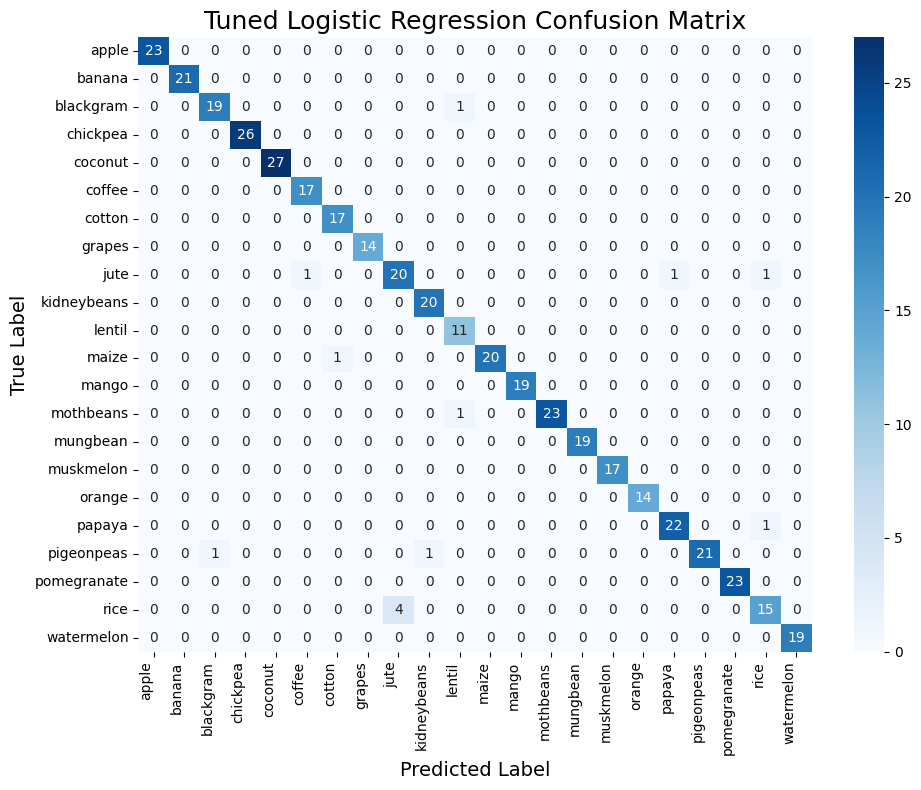


Tuned Decision Tree 
Accuracy: 0.9818181818181818
F1 Score: 0.9818088608800071
Classification Report:
               precision    recall  f1-score   support

       apple       1.00      1.00      1.00        23
      banana       1.00      1.00      1.00        21
   blackgram       0.95      1.00      0.98        20
    chickpea       1.00      1.00      1.00        26
     coconut       0.96      1.00      0.98        27
      coffee       1.00      1.00      1.00        17
      cotton       1.00      1.00      1.00        17
      grapes       1.00      1.00      1.00        14
        jute       0.91      0.87      0.89        23
 kidneybeans       1.00      1.00      1.00        20
      lentil       0.92      1.00      0.96        11
       maize       1.00      0.95      0.98        21
       mango       1.00      1.00      1.00        19
   mothbeans       1.00      0.92      0.96        24
    mungbean       1.00      1.00      1.00        19
   muskmelon       1.00      1.

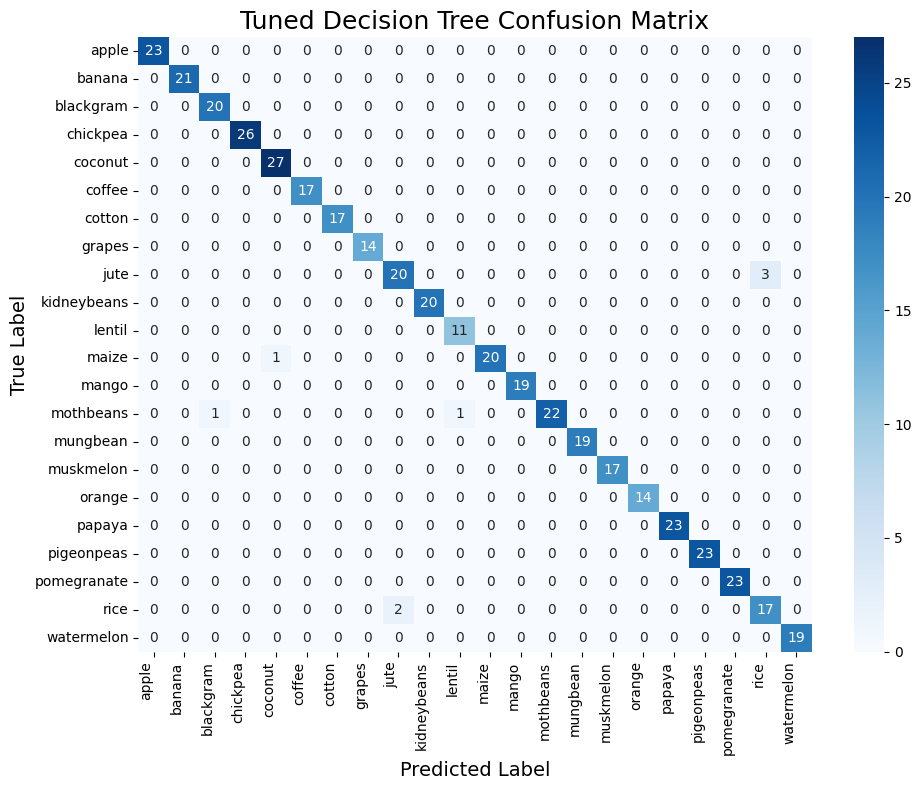


Tuned Random Forest 
Accuracy: 0.9931818181818182
F1 Score: 0.9931754816901672
Classification Report:
               precision    recall  f1-score   support

       apple       1.00      1.00      1.00        23
      banana       1.00      1.00      1.00        21
   blackgram       1.00      1.00      1.00        20
    chickpea       1.00      1.00      1.00        26
     coconut       1.00      1.00      1.00        27
      coffee       1.00      1.00      1.00        17
      cotton       1.00      1.00      1.00        17
      grapes       1.00      1.00      1.00        14
        jute       0.92      1.00      0.96        23
 kidneybeans       1.00      1.00      1.00        20
      lentil       0.92      1.00      0.96        11
       maize       1.00      1.00      1.00        21
       mango       1.00      1.00      1.00        19
   mothbeans       1.00      0.96      0.98        24
    mungbean       1.00      1.00      1.00        19
   muskmelon       1.00      1.

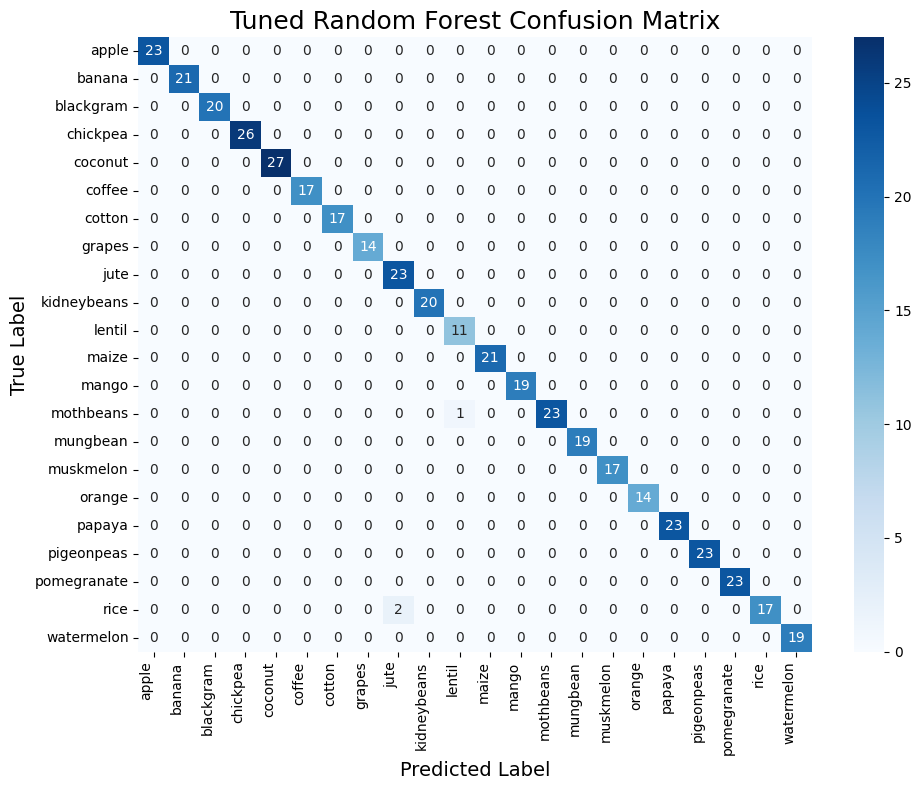

In [31]:
print("\nTEST PERFORMANCE (After Tuning)\n")

# LOGISTIC REGRESSION
logisticPredictionsTuned = bestLogisticRegressionModel.predict(featuresTest)
print("\nTuned Logistic Regression ")
print("Accuracy:", accuracy_score(targetTest, logisticPredictionsTuned))
print("F1 Score:", f1_score(targetTest, logisticPredictionsTuned, average='weighted'))
print("Classification Report:\n", classification_report(targetTest, logisticPredictionsTuned))
plotConfusionMatrixHeatmap(targetTest, logisticPredictionsTuned, "Tuned Logistic Regression Confusion Matrix")


# DECISION TREE
decisionTreePredictionsTuned = bestDecisionTreeModel.predict(featuresTest)
print("\nTuned Decision Tree ")
print("Accuracy:", accuracy_score(targetTest, decisionTreePredictionsTuned))
print("F1 Score:", f1_score(targetTest, decisionTreePredictionsTuned, average='weighted'))
print("Classification Report:\n", classification_report(targetTest, decisionTreePredictionsTuned))
plotConfusionMatrixHeatmap(targetTest, decisionTreePredictionsTuned, "Tuned Decision Tree Confusion Matrix")


# RANDOM FOREST
randomForestPredictionsTuned = bestRandomForestModel.predict(featuresTest)
print("\nTuned Random Forest ")
print("Accuracy:", accuracy_score(targetTest, randomForestPredictionsTuned))
print("F1 Score:", f1_score(targetTest, randomForestPredictionsTuned, average='weighted'))
print("Classification Report:\n", classification_report(targetTest, randomForestPredictionsTuned))
plotConfusionMatrixHeatmap(targetTest, randomForestPredictionsTuned, "Tuned Random Forest Confusion Matrix")


Saving the models using Joblib

In [32]:
save_path = "/content/drive/MyDrive/Models/"

# Create folder if it doesn't exist
os.makedirs(save_path, exist_ok=True)

# Save models
joblib.dump(bestLogisticRegressionModel, save_path + "LogisticRegressionModel.joblib")
joblib.dump(bestDecisionTreeModel, save_path + "DecisionTreeModel.joblib")
joblib.dump(bestRandomForestModel, save_path + "RandomForestModel.joblib")

print("\nModels saved successfully")



Models saved successfully
